# Importation des librairies

In [1]:
import json
import pandas as pd
import numpy as np
import re
import string
import emoji
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
# Télécharger les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')
# Préparation des outils
stop_words = set(stopwords.words('french'))
stemmer = FrenchStemmer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adminetu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adminetu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load the data

In [3]:
data = pd.read_json('comments_f1.json')
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)
data.head()

,name,appreciation,comments
0,Dahl de lentilles corail,4.5/5,[Recette de base que j'adapte en fonction des ...
1,Poêlée de panais,4.4/5,[Délicieux. C'est la première fois que je cuis...
2,Aubergines au four,4.3/5,[Facile à préparer et très sain. Il faut mettr...
3,Curry de pois chiches,4.8/5,"[après 10' j'ajoute des épinards., Rien à ajou..."
4,Galettes de pomme de terre,3.9/5,[Très bien. Je n'ai mis qu'un oignon que j'ai ...


# Data preprocessing

## 1- Data Cleaning 

### Detecter les éléments à nettoyer 

In [4]:
def has_url(comment):
    return bool(re.search(r'http[s]?://\S+', comment))

def has_mention(comment):
    return bool(re.search(r'@\w+', comment))

def has_uppercase_words(comment):
    return any(word.isupper() for word in comment.split())

def has_short_words(comment, threshold=3):
    return any(len(word) < threshold for word in comment.split())

def has_emojis(comment):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(comment))

def has_special_characters(comment):
    return bool(re.search(r'[^\w\s]', comment))

def has_duplicates(comments):
    seen = set()
    for comment in comments:
        if comment in seen:
            return True  # Doublon trouvé
        seen.add(comment)
    return False  # Aucun doublon

# Charger les données JSON
comments = data['comments'].explode().tolist()

# Statistiques de présence
stats = {
    "urls": 0,
    "mentions": 0,
    "uppercase_words": 0,
    "short_words": 0,
    "emojis": 0,
    "special_characters": 0,
    "duplicates": "Non"  # Initialise avec "Non"
}

# Vérification de la présence des éléments dans chaque commentaire
for comment in comments:
    if has_url(comment):
        stats['urls'] += 1
    if has_mention(comment):
        stats['mentions'] += 1
    if has_uppercase_words(comment):
        stats['uppercase_words'] += 1
    if has_short_words(comment):
        stats['short_words'] += 1
    if has_emojis(comment):
        stats['emojis'] += 1
    if has_special_characters(comment):
        stats['special_characters'] += 1

# Vérification des doublons
stats['duplicates'] = "Oui" if has_duplicates(comments) else "Non"

# Affichage des résultats
print("Présence dans les commentaires :")
for key, value in stats.items():
    if key == "duplicates":
        print(f"Doublons présents : {value}")
    else:
        print(f"{key.capitalize().replace('_', ' ')}: {value} occurrences")

Présence dans les commentaires :
Urls: 4 occurrences
Mentions: 0 occurrences
Uppercase words: 2063 occurrences
Short words: 21678 occurrences
Emojis: 320 occurrences
Special characters: 22202 occurrences
Doublons présents : Oui


### Supprimer les problèmes detectés 

In [5]:
def remove_urls(comment):
    """Supprime les URLs d'un commentaire."""
    return re.sub(r'http[s]?://\S+', '', comment)

def remove_emojis(comment):
    """Supprime tous les emojis d'un commentaire."""
    return emoji.replace_emoji(comment, replace='')

def clean_punctuation(sentence):
    """ Remplace certaines formes de ponctuation par des espaces et supprime d'autres, tout en préservant les apostrophes dans les contractions. """
    # Suppression de la ponctuation sauf les apostrophes utilisées dans les contractions
    sentence = re.sub(r'(?<!\w)[\'\"](?!\w)', '', sentence)  # Supprime les apostrophes et guillemets qui ne sont pas entourés par des lettres
    sentence = re.sub(r'[?|!|:|;|.|,|)|(|\|/]', ' ', sentence)  # Remplace d'autres ponctuations par des espaces
    sentence = sentence.replace("\n", " ")
    return sentence.strip()

def keep_alpha(sentence):
    """Conserve uniquement les caractères alphabétiques et gère certains caractères spéciaux."""
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-ZÀ-ÿ\']+', '', word)  # Inclure les caractères accentués français et apostrophes
        alpha_word = alpha_word.replace('œ', 'oe')  # Remplacer 'œ' par 'oe'
        alpha_sent += alpha_word + " "
    return alpha_sent.strip()

def remove_repeated_characters(comment):
    """Réduit les caractères répétés dans les mots pour éviter des variations comme 'délicieeuuuuux' à 'délicieux'."""
    return re.sub(r'(\w)(\1{2,})', r'\1', comment)

# Chargement et préparation des données
comments = data['comments'].explode().drop_duplicates().tolist()

# Application du nettoyage
cleaned_comments = []
for comment in comments:
    comment = remove_urls(comment)
    comment = remove_emojis(comment)
    comment = clean_punctuation(comment)
    comment = keep_alpha(comment)
    comment = remove_repeated_characters(comment)
    cleaned_comments.append(comment)
    
# Création d'un DataFrame à partir des commentaires nettoyés
cleaned_data = pd.DataFrame(cleaned_comments, columns=['cleaned_comments'])

# Afficher les premiers éléments nettoyés pour vérifier
print(cleaned_data.head())

                                    cleaned_comments
0  Recette de base que j'adapte en fonction des l...
1  Noubliez pas de faire cuire en avance les caro...
2  D'accord pour le commentaire sur les carottes ...
3  Très bonne recette réalisée avec des lentilles...
4              Facile à faire plat délicieux et sain


In [6]:
# Traitement des données
# Supprimer les caractères spéciaux et convertir la colonne 'appreciation' en numérique
data['appreciation'] = data['appreciation'].str.replace('/5', '').astype(float)

## 2- Visualisation

In [7]:
data['appreciation'].unique()

array([4.5, 4.4, 4.3, 4.8, 3.9, 4.7, 4.6, 5. , 4. , 4.1, 4.9, 4.2, 3.5,
       2.8, 3.6, 3.8, 2.9, 3.7, 3.1, 3.3])

In [8]:
# Convertir la colonne "appreciation" en chaîne de caractères
data['appreciation'] = data['appreciation'].astype(str)

# Extraire la partie numérique de la colonne 'appreciation' et la convertir en nombre à virgule flottante
data['appreciation'] = data['appreciation'].str.extract('(\d+\.\d+)').astype(float)

# Compter le nombre de chaque note
note_counts = data['appreciation'].value_counts()

# Calculer le pourcentage de chaque note
note_percentages = (note_counts / note_counts.sum()) * 100

In [9]:
# Compter le nombre de chaque note
note_counts = data['appreciation'].value_counts()

# Calculer le pourcentage de chaque note
note_percentages = (note_counts / note_counts.sum()) * 100

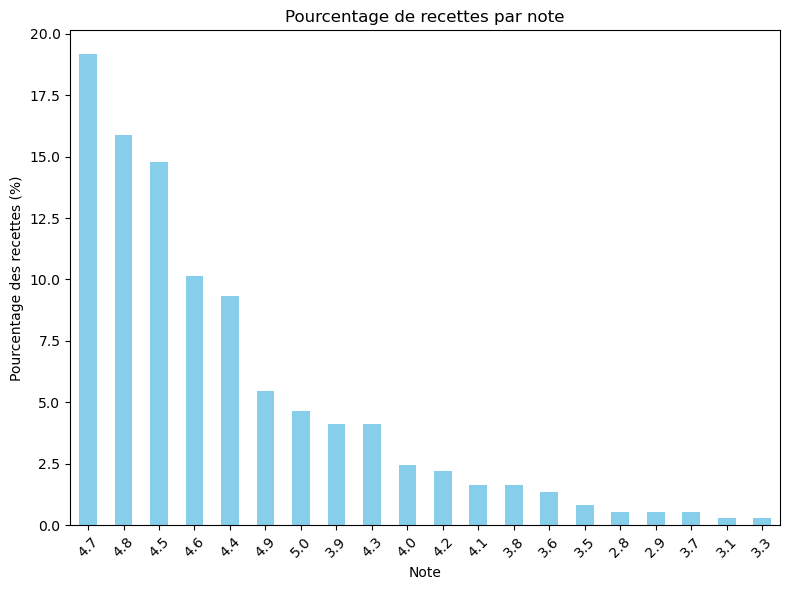

In [10]:
# Visualisation
plt.figure(figsize=(8, 6))
note_percentages.plot(kind='bar', color='skyblue')
plt.title('Pourcentage de recettes par note')
plt.xlabel('Note')
plt.ylabel('Pourcentage des recettes (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

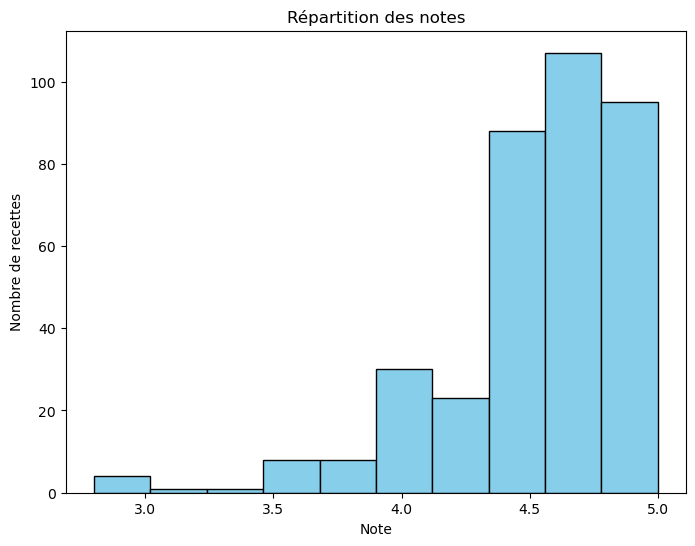

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(data['appreciation'], bins=10, color='skyblue', edgecolor='black')
plt.title('Répartition des notes')
plt.xlabel('Note')
plt.ylabel('Nombre de recettes')
plt.show()


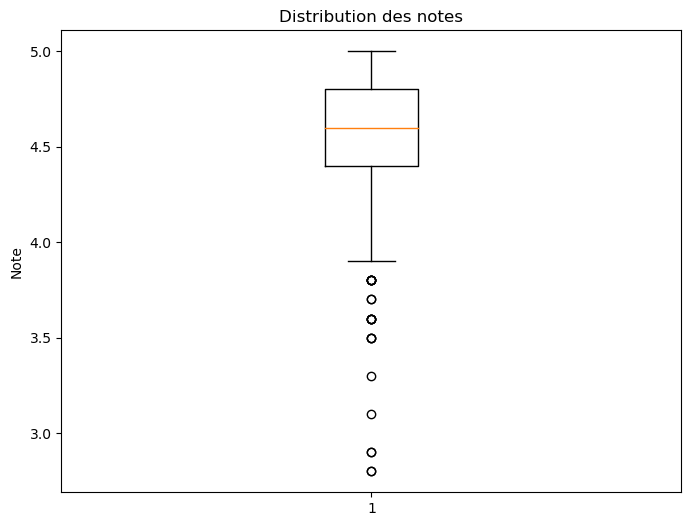

In [12]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['appreciation'])
plt.title('Distribution des notes')
plt.ylabel('Note')
plt.show()

### statistiques descriptives

In [13]:
print(data['appreciation'].describe())

count    365.000000
mean       4.512055
std        0.376606
min        2.800000
25%        4.400000
50%        4.600000
75%        4.800000
max        5.000000
Name: appreciation, dtype: float64


### observations des commentaires avec les emojis

In [14]:
# Créer une fonction pour vérifier si une chaîne contient des emojis
def contains_emojis(text):
    # Expression régulière pour correspondre à des séquences d'emojis
    emoji_pattern = re.compile("[\U0001F300-\U0001F5FF]|[\U0001F600-\U0001F64F]|[\U0001F680-\U0001F6FF]|[\U0001F700-\U0001F77F]|[\U0001F780-\U0001F7FF]|[\U0001F800-\U0001F8FF]|[\U0001F900-\U0001F9FF]|[\U0001FA00-\U0001FA6F]|[\U0001FA70-\U0001FAFF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]|[\U0001f926-\U0001f937]|[\U0001F1E0-\U0001F1FF]+")

    # Retourne True si la chaîne contient des emojis, sinon False
    return bool(re.search(emoji_pattern, text))

# Filtrer les commentaires qui contiennent des emojis
emoji_comments = data[data['comments'].apply(lambda x: any(contains_emojis(comment) for comment in x))]

# Afficher les commentaires qui contiennent des emojis
print(emoji_comments)

                                      _id  \
0    {'$oid': '647bab3240fabfafb506263d'}   
2    {'$oid': '647bab3240fabfafb506263f'}   
3    {'$oid': '647bab3240fabfafb5062640'}   
4    {'$oid': '647bab3240fabfafb5062641'}   
5    {'$oid': '647bab3240fabfafb5062642'}   
..                                    ...   
330  {'$oid': '647bbfc609762c56cbfe1db3'}   
333  {'$oid': '647bbfc609762c56cbfe1db6'}   
336  {'$oid': '647bbfc609762c56cbfe1db9'}   
348  {'$oid': '647bbfc609762c56cbfe1dc5'}   
354  {'$oid': '647bbfc609762c56cbfe1dcb'}   

                                                  name  appreciation  \
0                             Dahl de lentilles corail           4.5   
2                                   Aubergines au four           4.3   
3                                Curry de pois chiches           4.8   
4                           Galettes de pomme de terre           3.9   
5                      Lasagnes végétariennes (facile)           4.8   
..                         

In [15]:
# Imprimer le commentaire de la première ligne de données
print(data.iloc[0]['comments'])

["Recette de base que j'adapte en fonction des légumes de ma maison. C'est très sympa avec de la patate douce 😀🌞⛵🌊", 'N’oubliez pas de faire cuire en avance les carottes !! Sinon recette très bonne avec beaucoup de saveur', "D'accord pour le commentaire sur les carottes . Je n'ai pas trouvé ça ressemblant au Dahl Corail que j'avais l'habitude de manger dans les restaurants indiens. Décevant !", "Très bonne recette réalisée avec des lentilles vertes et davantage de lait de coco. J'ai ajouté des pommes de terre déjà cuites : un régal !", 'Facile à faire, plat délicieux et sain ??', 'Bien, je le fais régulièrement.', 'Tres bon plat. Facile à faire.', "C'est très bon et cela va bien avec tous les légumes de son choix, frais ou en conserve  j'ai mis 1 poivron vert, 1 rouge et des carottes violettes. Je n'avais pas de lait de coco donc j'ai mis de la crème de soja.", 'Facile à faire et excellent', 'Délicieux et consistant ! Les lentilles apportent les protéines et le fer.', 'Très bon merci.'

### Nous avons décidé de supprimer les emojis puisqu

## 3- Preprocessing 

In [6]:
def tokenize_sentences(text):
    """Tokenise le texte en mots."""
    return word_tokenize(text, language='french')

def remove_stop_words(tokens):
    """Enlève les stop words de la liste de tokens."""
    return [word for word in tokens if word not in stop_words]

def stem_words(words):
    """Applique le stemming sur la liste de mots."""
    return [stemmer.stem(word) for word in words]

def labelize_scores(score):
    """Convertit un score textuel en une étiquette numérique simple."""
    return int(round(float(score.split('/')[0])))

def preprocess_text(text):
    """Applique le tokenization, la suppression des stop words, et le stemming."""
    tokens = tokenize_sentences(text)
    filtered_tokens = remove_stop_words(tokens)
    stemmed_tokens = stem_words(filtered_tokens)
    return stemmed_tokens


### Application du code de pretraitement 

In [7]:
# Chargement des données nettoyées
cleaned_comments = cleaned_data['cleaned_comments'].explode().drop_duplicates().tolist()

# Application du prétraitement
preprocessed_comments = []
for comment in cleaned_comments:
    processed_text = preprocess_text(comment)
    # Joindre les tokens pour former une chaîne de caractères avant de les ajouter à la liste
    preprocessed_comments.append(' '.join(processed_text))

# Création d'un DataFrame à partir des commentaires prétraités
preprocessed_data = pd.DataFrame(preprocessed_comments, columns=['preprocessed_comments'])

# Application de la fonction labelize_scores à la colonne des scores
data['appreciation'] = data['appreciation'].apply(labelize_scores) 

# Affichage des premiers éléments prétraités pour vérifier
print(preprocessed_data.head())

# Affichage des scores transformés pour vérifier
print(data[['appreciation']])

                               preprocessed_comments
0  recet bas j'adapt fonction légum maison c'est ...
1  noubl fair cuir avanc carott sinon recet tres ...
2  d'accord commentair carott je n'ai trouv ça re...
3  tres bon recet réalis lentill vert davantag la...
4                        facil fair plat délici sain
     appreciation
0               4
1               4
2               4
3               5
4               4
..            ...
360             4
361             5
362             4
363             4
364             5

[365 rows x 1 columns]


In [12]:
print(data)

                                         name  appreciation  \
0                    Dahl de lentilles corail             4   
1                            Poêlée de panais             4   
2                          Aubergines au four             4   
3                       Curry de pois chiches             5   
4                  Galettes de pomme de terre             4   
..                                        ...           ...   
360     Omelette aux lardons, champignons....             4   
361           Omelette des jours sans courses             5   
362      Oeufs brouillés aux oeufs... de lump             4   
363  Oeufs brouillés à la tomate simplissimes             4   
364                        Omelette savoyarde             5   

                                              comments  
0    [Recette de base que j'adapte en fonction des ...  
1    [Délicieux. C'est la première fois que je cuis...  
2    [Facile à préparer et très sain. Il faut mettr...  
3    [après 10'

## Transformation du texte en numerique 